# PCA Analysis for Reduction of Area Prediction

## Why PCA for Reduction of Area?

**Problem**: The dataset contains 50+ features including chemical composition, welding parameters, and process conditions. Many of these features are highly correlated.

**Why PCA is necessary**:

1. **Multicollinearity**: Chemical elements like C, Mn, Si are often correlated due to steel composition requirements. This creates redundant information and unstable model coefficients.

2. **Dimensionality Curse**: With sufficient samples and 50+ features, PCA reduces features while retaining 90-95% of variance, improving model generalization.

3. **Noise Reduction**: Minor variations in measurements contribute little to prediction but add noise. PCA captures systematic variation while filtering noise.

4. **Computational Efficiency**: Training models on 15-20 principal components is faster than 50+ original features, especially for GridSearchCV with cross-validation.

**About Reduction of Area**: Reduction of Area (%) is a ductility measure indicating the percentage decrease in cross-sectional area at the fracture point. It's a critical quality indicator for material toughness and is influenced by microstructure, chemical composition, and welding parameters.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [23]:
os.makedirs('pca_model', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [ ]:
df = pd.read_csv('../../welddatabase/welddb_pca.csv')
print(f"Prepared dataset shape: {df.shape}")

Prepared dataset shape: (1652, 52)


In [4]:
# Check Reduction of Area data availability
red_area_available = df['Reduction_Area_%'].notna().sum()
print(f"Reduction of Area data available: {red_area_available} samples ({red_area_available/len(df)*100:.1f}%)")

Reduction of Area data available: 705 samples (42.7%)


In [5]:
target_columns = ['Yield_Strength_MPa', 'UTS_MPa', 'Elongation_%', 
                  'Reduction_Area_%', 'Charpy_Temp_C', 'Charpy_Energy_J',
                  'Hardness_kg_mm2', 'FATT_50%', 'Primary_Ferrite_%',
                  'Ferrite_2nd_Phase_%', 'Acicular_Ferrite_%', 'Martensite_%',
                  'Ferrite_Carbide_%']

df_red = df[df['Reduction_Area_%'].notna()].copy()
y_red = df_red['Reduction_Area_%'].copy()
X_red = df_red.drop(columns=target_columns)

print(f"\nFiltered dataset for Reduction of Area:")
print(f"  Samples: {len(df_red)}")
print(f"  Features: {X_red.shape[1]}")
print(f"  Target: Reduction_Area_%")


Filtered dataset for Reduction of Area:
  Samples: 705
  Features: 39
  Target: Reduction_Area_%


## Missing Value Imputation

**Why KNN Imputation?**

KNN (K-Nearest Neighbors) imputation is more robust than simple mean/median imputation because:

1. **Preserves Relationships**: Uses similarity between samples to impute values, maintaining correlations between features
2. **Handles MCAR/MAR/MNAR**: Works well with Missing Completely At Random, Missing At Random, and even some Missing Not At Random patterns
3. **Distance-based**: `weights='distance'` gives more influence to closer neighbors, improving accuracy
4. **Non-parametric**: No assumptions about data distribution

**Parameters**:
- `n_neighbors=5`: Balance between local patterns and stability
- `weights='distance'`: Inverse distance weighting for better accuracy

In [6]:
missing_before = X_red.isnull().sum().sum()
print(f"Missing values before imputation: {missing_before}")

imputer = KNNImputer(n_neighbors=5, weights='distance')
X_red_imputed = imputer.fit_transform(X_red)

missing_after = pd.DataFrame(X_red_imputed).isnull().sum().sum()
print(f"Missing values after imputation: {missing_after}")
print(f"Imputation complete: {missing_before} values imputed")

Missing values before imputation: 139
Missing values after imputation: 0
Imputation complete: 139 values imputed


In [7]:
joblib.dump(imputer, 'pca_model/imputer.pkl')
print("Imputer saved: pca_model/imputer.pkl")

Imputer saved: pca_model/imputer.pkl


## Principal Component Analysis (PCA)

**Strategy**: Retain 90% of variance

This threshold balances:
- **Information preservation**: 90% of original variance captured
- **Dimensionality reduction**: Typically reduces 50+ features to 15-20 components
- **Noise filtering**: Discards 10% of variance (often noise)
- **Model performance**: Sufficient information for accurate predictions

In [8]:
pca = PCA(n_components=0.90, random_state=42)
X_red_pca = pca.fit_transform(X_red_imputed)

print(f"Original features: {X_red_imputed.shape[1]}")
print(f"PCA components: {X_red_pca.shape[1]}")
print(f"Variance retained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Dimensionality reduction: {(1 - X_red_pca.shape[1]/X_red_imputed.shape[1])*100:.1f}%")

Original features: 39
PCA components: 17
Variance retained: 0.9074
Dimensionality reduction: 56.4%


In [9]:
joblib.dump(pca, 'pca_model/pca_model.pkl')
print("PCA model saved: pca_model/pca_model.pkl")

PCA model saved: pca_model/pca_model.pkl


## Save Transformed Data

In [22]:
pc_columns = [f'PC{i+1}' for i in range(X_red_pca.shape[1])]
df_red_pca = pd.DataFrame(X_red_pca, columns=pc_columns, index=df_red.index)
df_red_pca['Reduction_Area_%'] = y_red.values

df_red_pca.to_csv('data/welddb_pca_reduction_area.csv', index=False)
print(f"Shape: {df_red_pca.shape}")

OSError: Cannot save file into a non-existent directory: 'data'

## Visualization 1: Cumulative Explained Variance

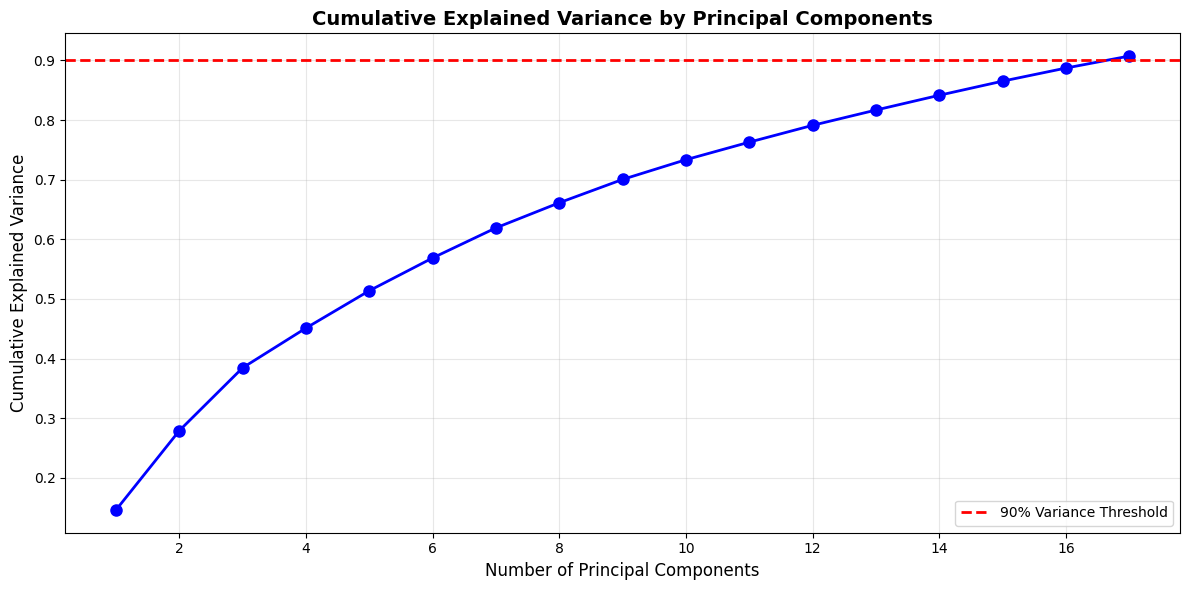

Components needed for 90% variance: 17


In [11]:
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0.90, color='r', linestyle='--', linewidth=2, label='90% Variance Threshold')
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance by Principal Components', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('figures/cumulative_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Components needed for 90% variance: {X_red_pca.shape[1]}")

## Visualization 2: Individual Component Variance

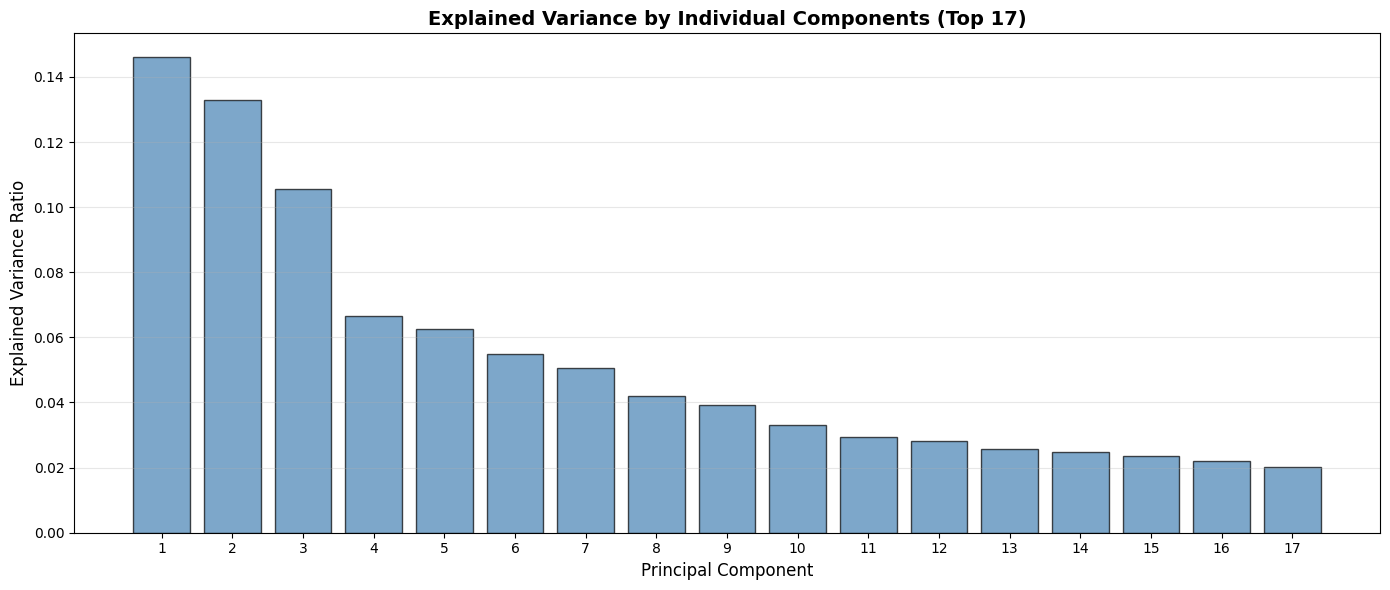

In [12]:
n_components_plot = min(20, len(pca.explained_variance_ratio_))

plt.figure(figsize=(14, 6))
plt.bar(range(1, n_components_plot + 1), 
        pca.explained_variance_ratio_[:n_components_plot], 
        alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title(f'Explained Variance by Individual Components (Top {n_components_plot})', fontsize=14, fontweight='bold')
plt.xticks(range(1, n_components_plot + 1))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('figures/individual_variance.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 3: PCA Components 2D Scatter

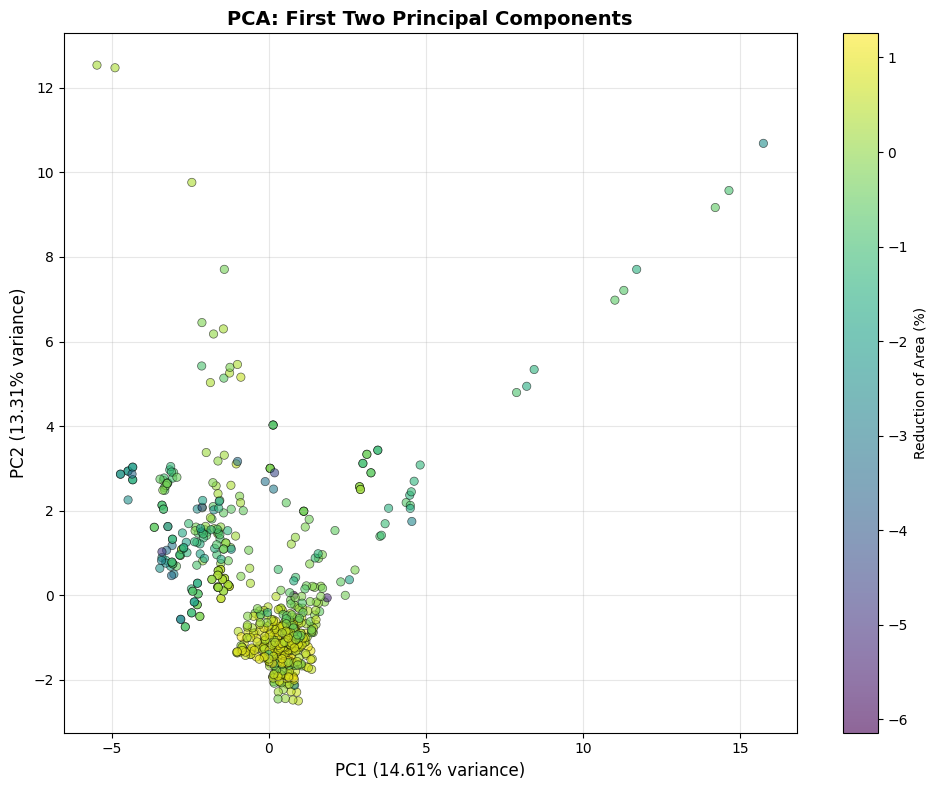

In [13]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_red_pca[:, 0], X_red_pca[:, 1], 
                     c=y_red, cmap='viridis', alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Reduction of Area (%)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA: First Two Principal Components', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/pca_2d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 4: PCA Components 3D Scatter

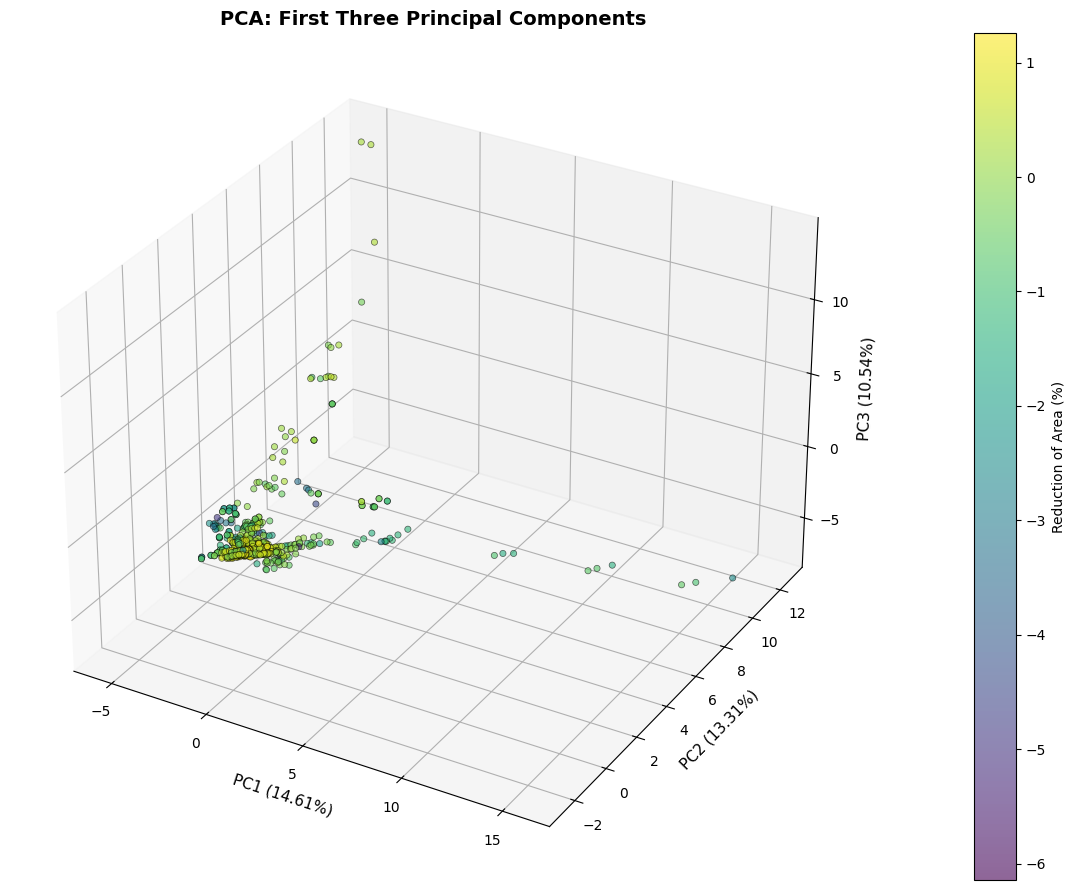

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_red_pca[:, 0], X_red_pca[:, 1], X_red_pca[:, 2],
                    c=y_red, cmap='viridis', alpha=0.6, edgecolors='k', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})', fontsize=11)
ax.set_title('PCA: First Three Principal Components', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Reduction of Area (%)', pad=0.1)
plt.tight_layout()
plt.savefig('figures/pca_3d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 5: Feature Loadings Heatmap

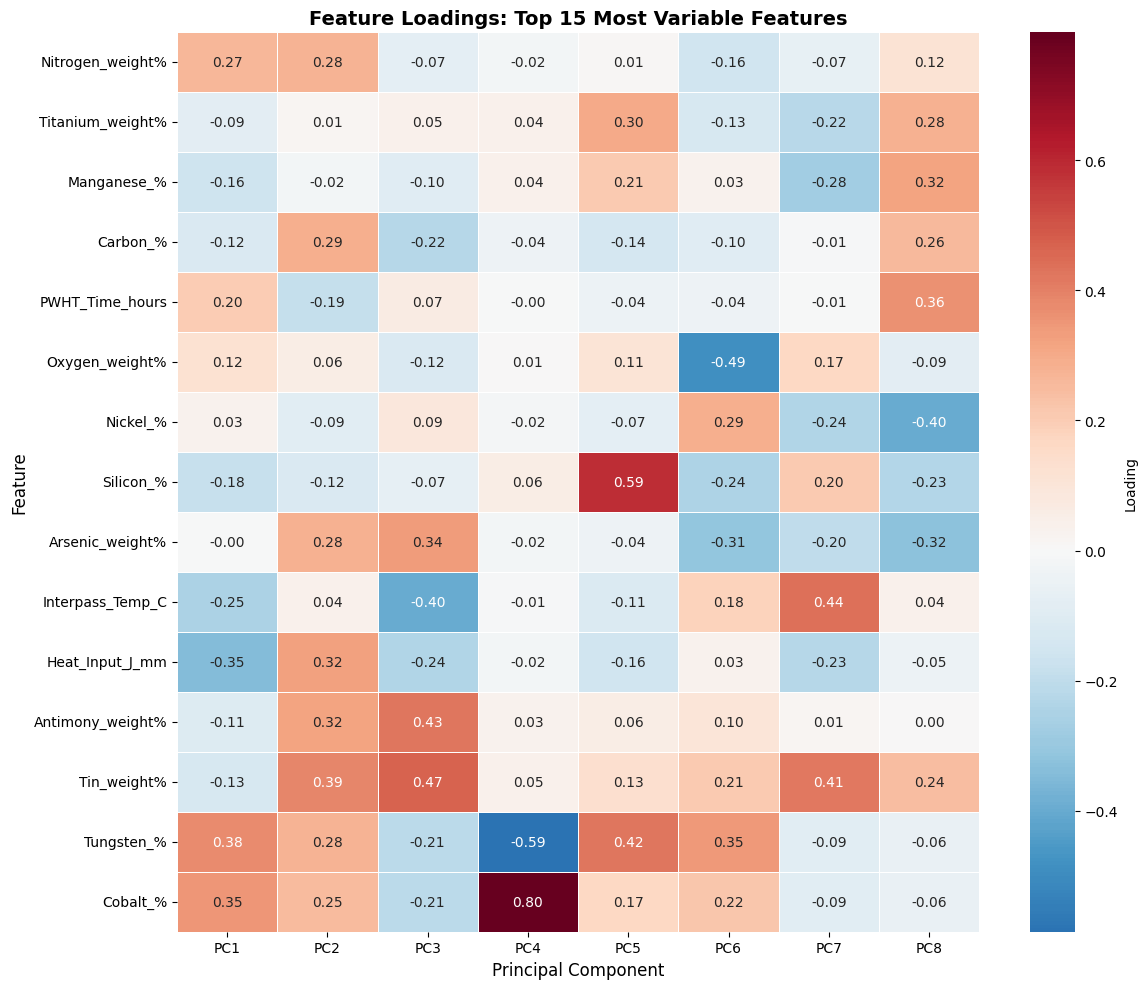

In [15]:
n_pcs_heatmap = min(8, X_red_pca.shape[1])
pcs_to_show = pc_columns[:n_pcs_heatmap]

loadings = pd.DataFrame(
    pca.components_.T,
    columns=pc_columns,
    index=X_red.columns
)

feature_variance = np.var(X_red_imputed, axis=0)
top_varying_features = X_red.columns[np.argsort(feature_variance)[-15:]]

plt.figure(figsize=(12, 10))
sns.heatmap(loadings.loc[top_varying_features, pcs_to_show], 
            annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Loading'}, linewidths=0.5)
plt.title(f'Feature Loadings: Top {len(top_varying_features)} Most Variable Features', 
          fontsize=14, fontweight='bold')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('figures/loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 6: Top Feature Loadings for PC1 and PC2

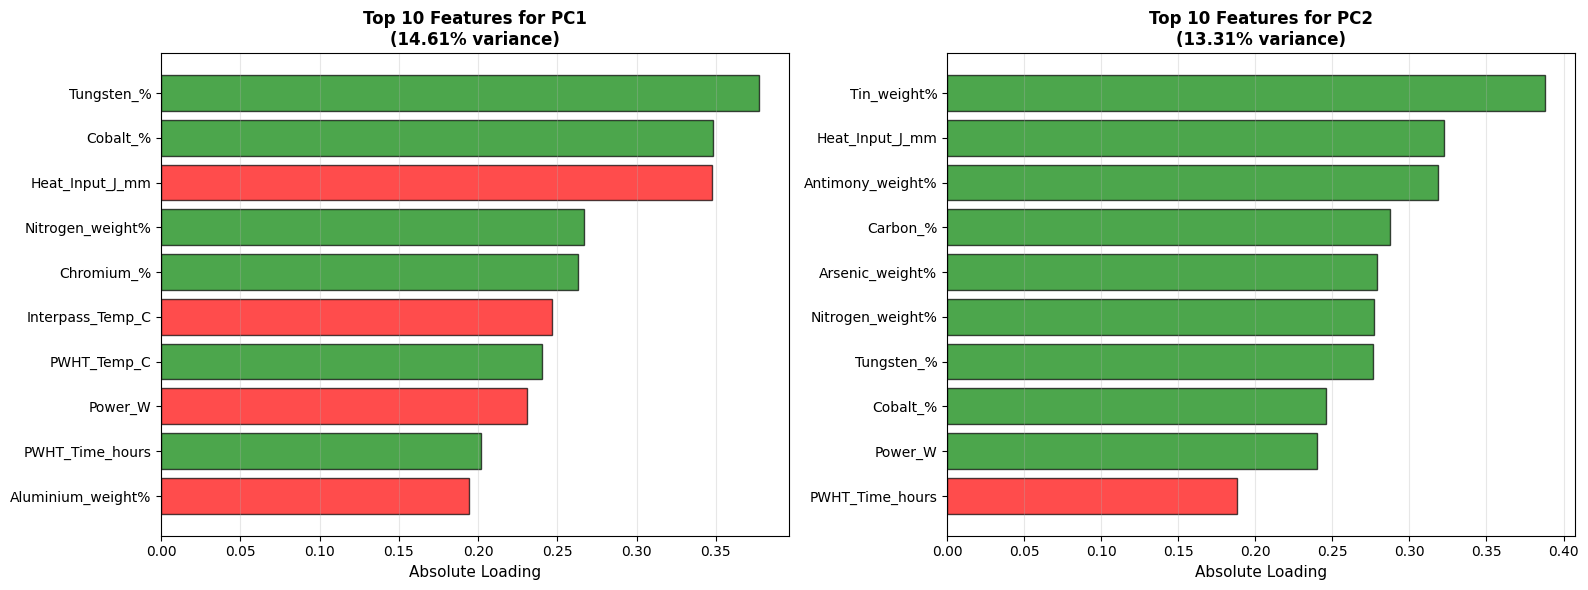

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, ax in enumerate(axes):
    loadings_pc = loadings[f'PC{i+1}'].abs().sort_values(ascending=False).head(10)
    colors = ['red' if loadings[f'PC{i+1}'][feat] < 0 else 'green' for feat in loadings_pc.index]
    
    ax.barh(range(len(loadings_pc)), loadings_pc.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(loadings_pc)))
    ax.set_yticklabels(loadings_pc.index)
    ax.set_xlabel('Absolute Loading', fontsize=11)
    ax.set_title(f'Top 10 Features for PC{i+1}\n({pca.explained_variance_ratio_[i]:.2%} variance)', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig('figures/top_loadings_pc1_pc2.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 7: Biplot (PC1 vs PC2)

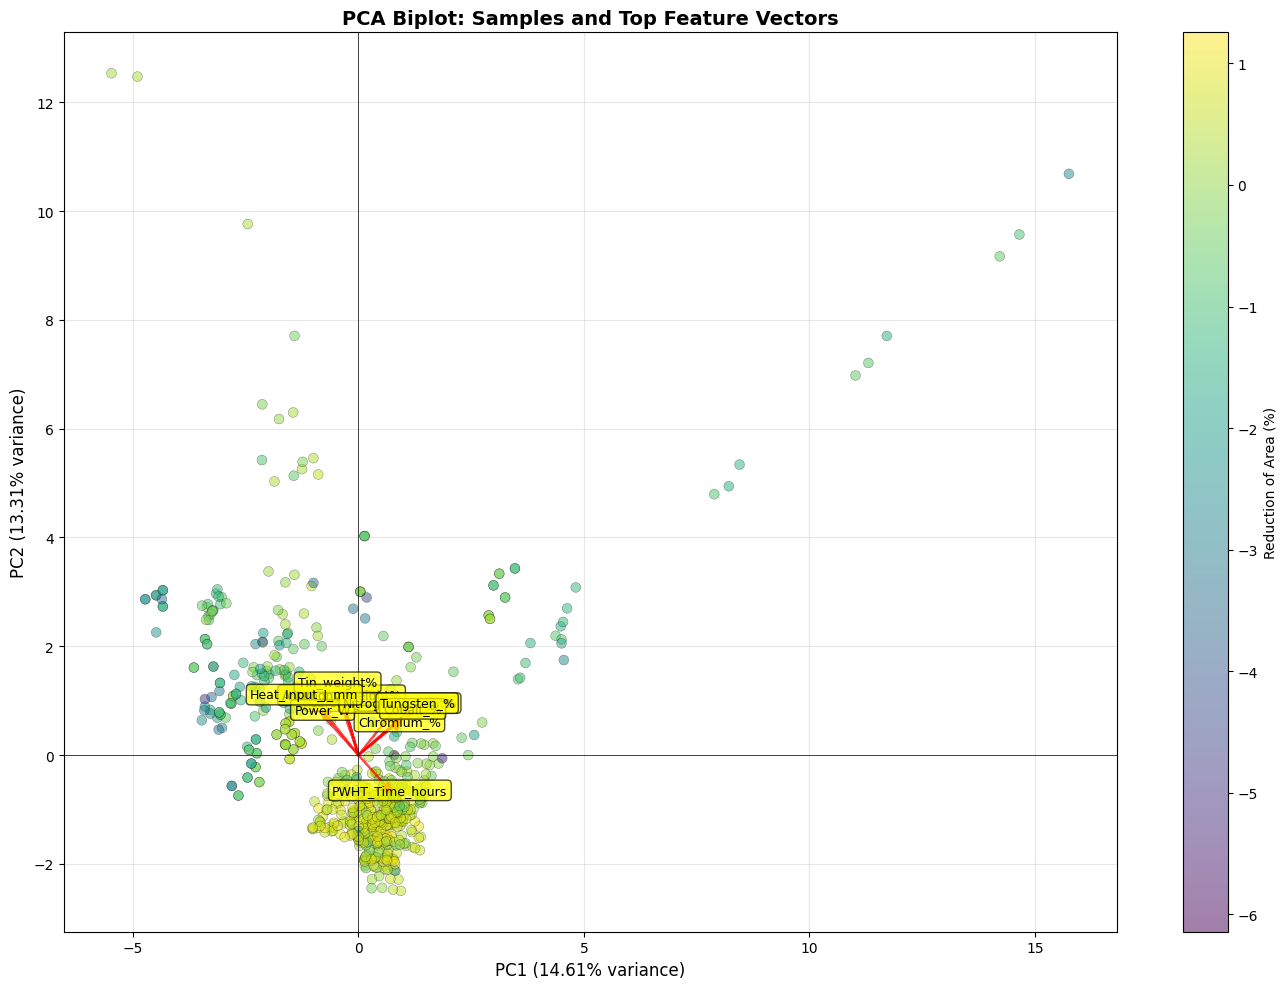

In [17]:
fig, ax = plt.subplots(figsize=(14, 10))

ax.scatter(X_red_pca[:, 0], X_red_pca[:, 1], 
          c=y_red, cmap='viridis', alpha=0.5, edgecolors='k', linewidth=0.3, s=50)

scale_factor = 3
top_n_features = 10
feature_importance = np.abs(pca.components_[0]) + np.abs(pca.components_[1])
top_features_idx = np.argsort(feature_importance)[-top_n_features:]

for i in top_features_idx:
    ax.arrow(0, 0, 
            pca.components_[0, i] * scale_factor, 
            pca.components_[1, i] * scale_factor,
            head_width=0.2, head_length=0.2, fc='red', ec='red', alpha=0.7, linewidth=1.5)
    ax.text(pca.components_[0, i] * scale_factor * 1.15, 
           pca.components_[1, i] * scale_factor * 1.15,
           X_red.columns[i], fontsize=9, ha='center', va='center',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax.set_title('PCA Biplot: Samples and Top Feature Vectors', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

plt.colorbar(ax.collections[0], label='Reduction of Area (%)', ax=ax)
plt.tight_layout()
plt.savefig('figures/biplot.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 8: Correlation Matrix of Top PCs

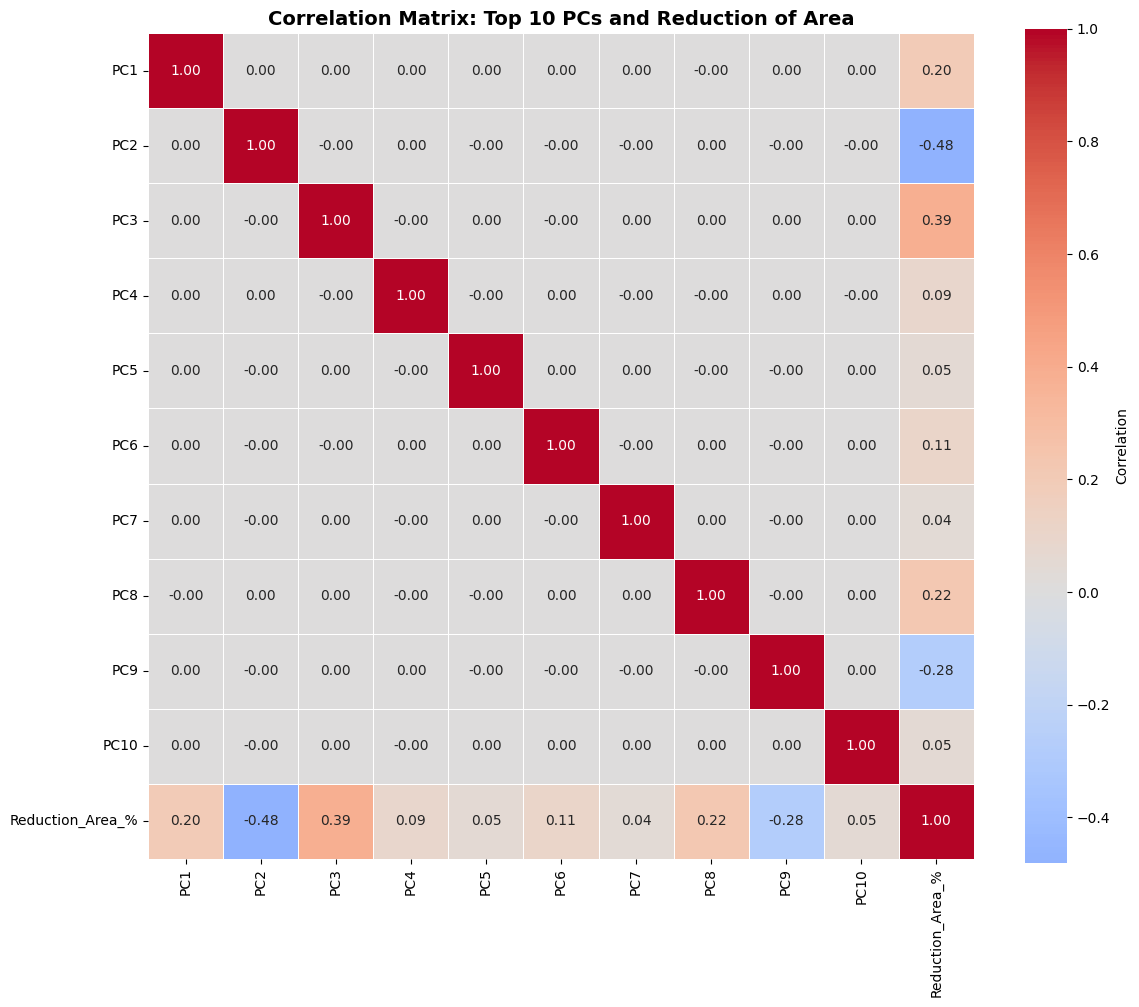


Correlation with Reduction of Area:
Reduction_Area_%    1.000000
PC3                 0.389802
PC8                 0.219347
PC1                 0.197193
PC6                 0.106139
PC4                 0.086225
PC10                0.050176
PC5                 0.047537
PC7                 0.041063
PC9                -0.275948
PC2                -0.481249
Name: Reduction_Area_%, dtype: float64


In [18]:
n_pcs_corr = min(10, X_red_pca.shape[1])
pca_df_subset = pd.DataFrame(X_red_pca[:, :n_pcs_corr], 
                             columns=[f'PC{i+1}' for i in range(n_pcs_corr)])
pca_df_subset['Reduction_Area_%'] = y_red.values

corr_matrix = pca_df_subset.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title(f'Correlation Matrix: Top {n_pcs_corr} PCs and Reduction of Area', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/pca_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation with Reduction of Area:")
print(corr_matrix['Reduction_Area_%'].sort_values(ascending=False).head(11))

## Visualization 9: PC Distribution

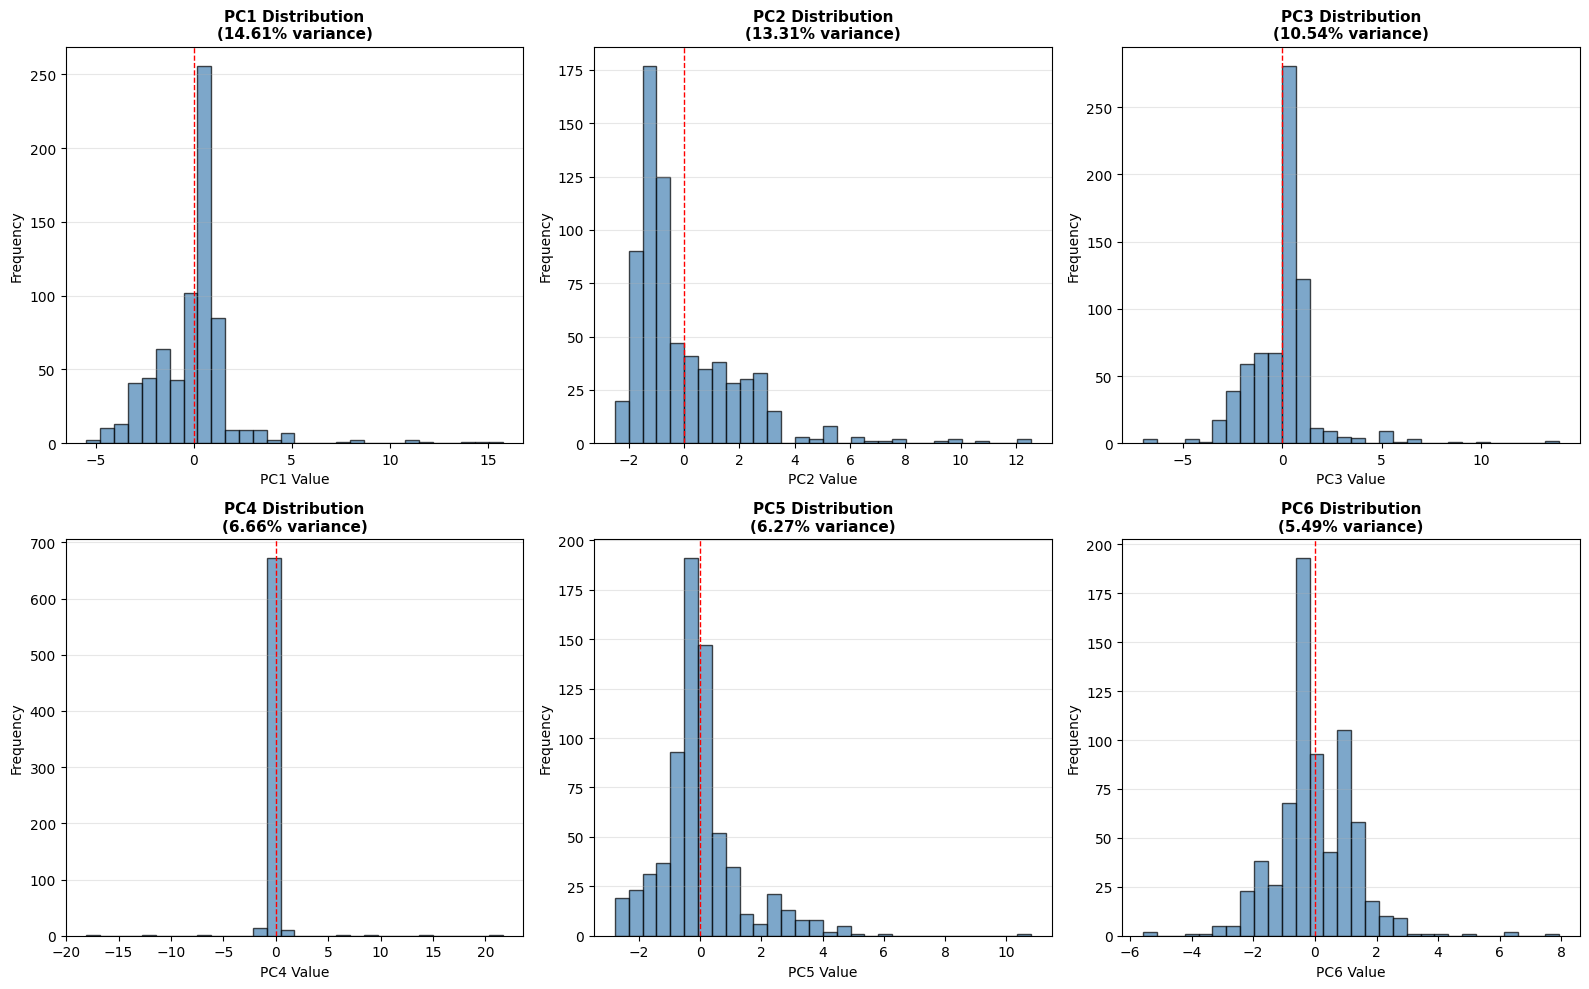

In [19]:
n_pcs_dist = min(6, X_red_pca.shape[1])
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i in range(n_pcs_dist):
    axes[i].hist(X_red_pca[:, i], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(f'PC{i+1} Distribution\n({pca.explained_variance_ratio_[i]:.2%} variance)', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel(f'PC{i+1} Value', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].grid(True, alpha=0.3, axis='y')
    axes[i].axvline(0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig('figures/pc_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 10: Pairplot of Top 4 PCs

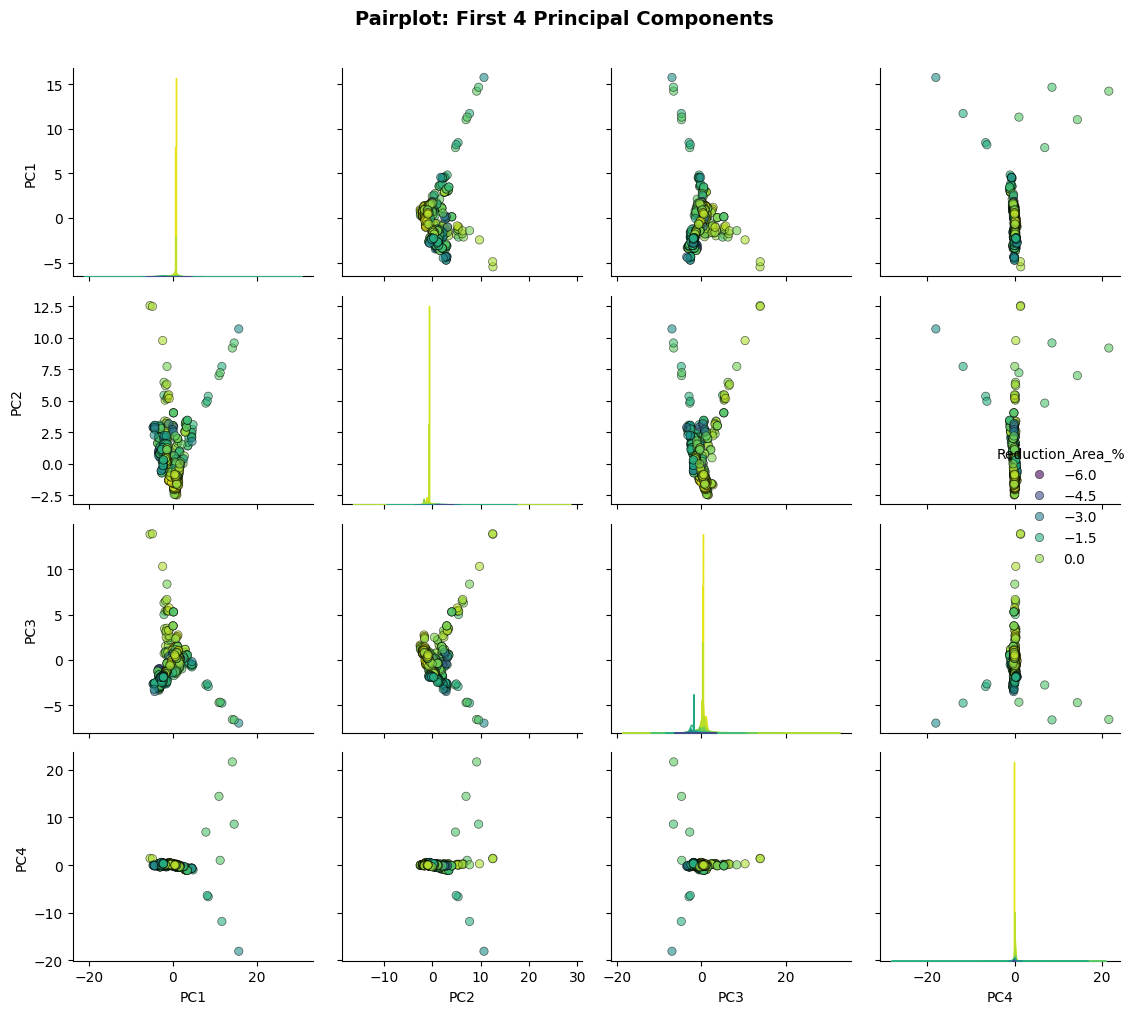

In [20]:
n_pcs_pair = min(4, X_red_pca.shape[1])
pca_df_pair = pd.DataFrame(X_red_pca[:, :n_pcs_pair], 
                           columns=[f'PC{i+1}' for i in range(n_pcs_pair)])
pca_df_pair['Reduction_Area_%'] = y_red.values

pairplot = sns.pairplot(pca_df_pair, hue='Reduction_Area_%', palette='viridis', 
                       plot_kws={'alpha': 0.6, 'edgecolor': 'k', 'linewidth': 0.5},
                       diag_kind='kde', corner=False)
pairplot.fig.suptitle('Pairplot: First 4 Principal Components', y=1.01, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/pca_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 12: Feature Contribution to Top PCs

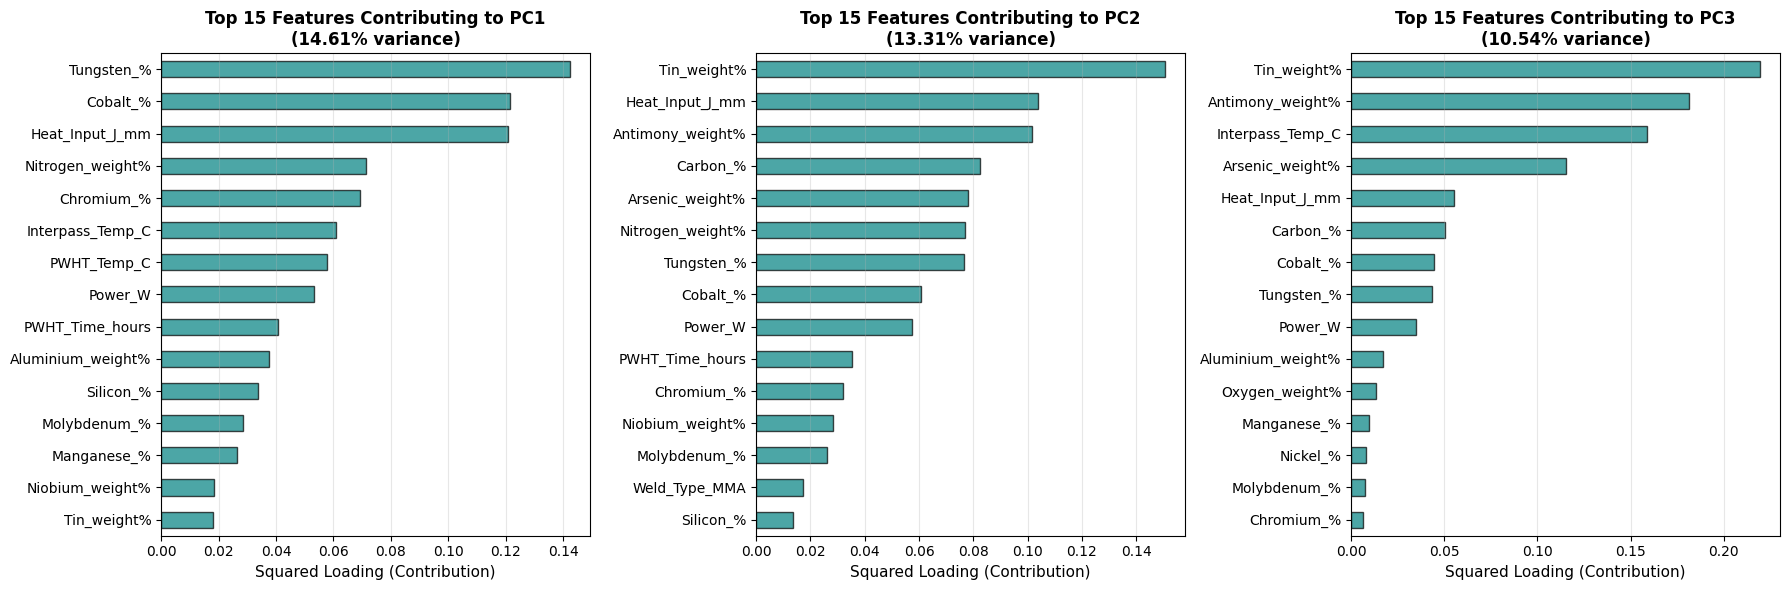

In [21]:
n_pcs_contrib = min(3, X_red_pca.shape[1])
fig, axes = plt.subplots(1, n_pcs_contrib, figsize=(18, 6))

if n_pcs_contrib == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    contributions = pd.Series(pca.components_[i] ** 2, index=X_red.columns).sort_values(ascending=False).head(15)
    contributions.plot(kind='barh', ax=ax, color='teal', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Squared Loading (Contribution)', fontsize=11)
    ax.set_title(f'Top 15 Features Contributing to PC{i+1}\n({pca.explained_variance_ratio_[i]:.2%} variance)', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig('figures/feature_contributions.png', dpi=300, bbox_inches='tight')
plt.show()